# Stock Movement Prediction
Dataset: [S&P 500](https://www.sharecast.com/index/SP_500/prices/download)<br>
Goal: Predict future **close price**

Implement by three methods:
1. Linear Regression
2. SVM
3. Neural Network(LSTM)

In [39]:
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from datetime import datetime

### Build training and testing data

In [40]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [41]:
def build_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['date'] = df['Date'].dt.day
    df['day'] = df['Date'].dt.dayofweek
    df = df.drop(['Date'], axis=1)
    return df
train = build_data(train)
test = build_data(test)
train.head()

,Open Price,Close Price,High Price,Low Price,Volume,year,month,date,day
0,902.99,931.80,934.73,899.35,4048270080,2009,1,2,4
1,929.17,927.45,936.63,919.53,5413910016,2009,1,5,0
2,931.17,934.70,943.85,927.28,5392620032,2009,1,6,1
3,927.45,906.65,927.45,902.37,4704940032,2009,1,7,2
4,905.73,909.73,910.00,896.81,4991549952,2009,1,8,3


產生training和testing資料，收盤價（Close Price）是要預測的label，所以單獨切出來。<br>

In [42]:
# Create labels
train_y = train['Close Price'].values
test_y = test['Close Price'].values

train_x = train
test_x = test

In [43]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2264, 9)
(2264,)
(271, 9)
(271,)


## Linear Regression
x_train: 利用前30天的Close Price作為Features，shape為(2234, 30)

In [44]:
PASTDAY = 30
x_train = []
x_test = []
def past_month(df, out):
    for i, day in enumerate(range(df.shape[0] - PASTDAY)):
        val = np.asarray(df.loc[i:i+PASTDAY-1]['Close Price'])
        out.append(val)

past_month(train_x, x_train)
past_month(test_x, x_test)
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
train_y = train_y[PASTDAY:]
test_y = test_y[PASTDAY:]

In [45]:
print("x_train:", x_train.shape)
pd.DataFrame(x_train).head()

x_train: (2263, 1)


,0
0,931.80
1,927.45
2,934.70
3,906.65
4,909.73


In [34]:
print("train_y:", train_y.shape)
pd.DataFrame(train_y).head()

train_y: (2263,)
927.45


In [35]:
print("x_test:", x_test.shape)
pd.DataFrame(x_test).head()

x_test: (270, 1)
[2639.44]


In [36]:
print("test_y:", test_y.shape)
pd.DataFrame(test_y).head()

test_y: (270,)
2629.57


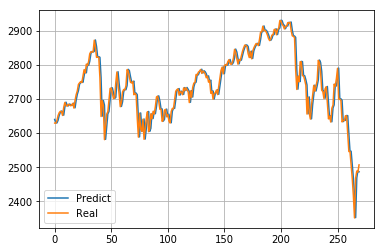

Average error: 0.0071209300783821585


In [37]:
regr = linear_model.LinearRegression()
regr.fit(x_train, train_y)
y_pred = regr.predict(x_test)
plt.plot(y_pred, label='Predict')
plt.plot(test_y, label='Real')
plt.grid()
plt.legend(loc='lower left')
plt.show()
err = 0
for pred, real in zip(y_pred, test_y):
    err += abs((pred - real)/real)
print("Average error:", err/len(y_pred))

## SVM

## Neural Network(LSTM)